# FastAI Kaggle Starter Kit

WNixalo 22:31 21-Jan-2018

Following along with: [this FastAI Kaggle starter kit](https://www.kaggle.com/timolee/fastai-kaggle-starter-kit-lb-0-33/) notebook. Hopefully I can find a methodology that doesn't get me ass poor results.

## 1. Importing Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch

import shutil
import os
# sys.path.append('../repos/fastai/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter
from scipy.ndimage import filters

## 1.1 Importing FastAI Libraries

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
torch.cuda.current_device()

0

## 2. Data Prep

In [5]:
train_df = pd.read_json('data/train.json')
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')

In [6]:
print(train_df.shape)

(1604, 5)


## 2.1 Organizing Folders + Files for the FastAI Library

In [7]:
PATH = 'data/'

### Set file locations

In [8]:
shipPath = 'data/train/ship/'
icePath  = 'data/train/ice/'
shipValid= 'data/valid/ship/'
iceValid = 'data/valid/ice/'
testPath = 'data/test/'

### Clean up existing folders (drop all files)

Clears out the folders so that files aren't double generated

In [9]:
if not os.path.exists('data/train/'):
    os.mkdir('data/train/')
    os.mkdir(shipPath)
    os.mkdir(icePath)
if not os.path.exists('data/valid/'):
    os.mkdir('data/valid/')
    os.mkdir(shipValid)
    os.mkdir(iceValid)
if not os.path.exists('data/test/'):
    os.mkdir('data/test/')

shutil.rmtree(shipPath)
os.mkdir(shipPath)

shutil.rmtree(icePath)
os.mkdir(icePath)

shutil.rmtree(shipValid)
os.mkdir(shipValid)

shutil.rmtree(iceValid)
os.mkdir(iceValid)

shutil.rmtree(testPath)
os.mkdir(testPath)

os.makedirs('tmp', exist_ok=True)

## 2.2 Image Creation (to Jpegs)

### Creating training dataset in `train/iceberg` and `train/ship`

#### Load Input Json

In [10]:
train_df.shape

(1604, 5)

In [11]:
icebergs = train_df[train_df.is_iceberg==1]
ships    = train_df[train_df.is_iceberg==0]

#### Pull out the different Bands

pictures to increase the dataset size. Some further development of combining the two matrices is possible

https://www.kaggle.com/keremt/getting-color-composites

In [12]:
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75,75)
        band_2 = np.array(row['band_2']).reshape(75,75)
        band_z = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_z + abs(band_z.min())) / np.max((band_z + abs(band_z.min())))
        
        rgb = np.dstack((r,g,b))
        rgb_arrays.append(rgb)
    
    return np.array(rgb_arrays)

In [13]:
iceberg_imgs = color_composite(icebergs)
ship_imgs    = color_composite(ships)

In [14]:
iceberg_imgs.shape

(753, 75, 75, 3)

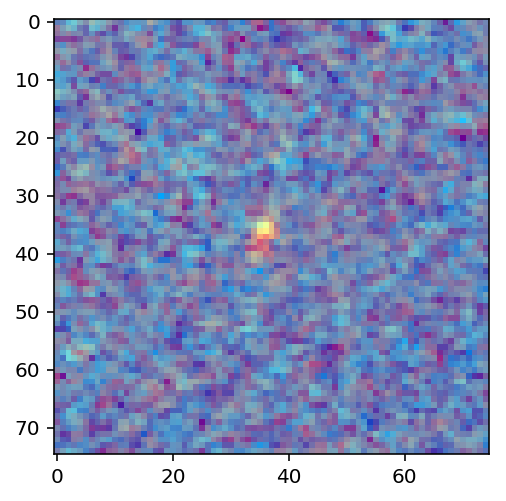

In [15]:
plt.imshow(iceberg_imgs[0])

#### Functions to save to disk

These two functions turn the long raveled vectors into matrices, and then save them to `.png` files with matplotlib.

In [16]:
import matplotlib

def vec2Mat(vec):
    return np.reshape(np.array(vec),(75,75))

def saveMat(array, filename):
    matplotlib.image.imsave(filename, array)

#### Saving each training set to `.png` to its respective folder

Loops through all different datasets and saves them to disk

In [17]:
for i,x in enumerate(iceberg_imgs):
    matplotlib.image.imsave(f'data/train/ice/ice_{i}.png', x)

In [18]:
for i,x in enumerate(ship_imgs):
    matplotlib.image.imsave(f'data/train/ship/ship_{i}.png', x)

#### Creating the testset files in the `test` directory

In [19]:
test_df = pd.read_json('data/test.json')

In [20]:
test_df.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [21]:
test_imgs = color_composite(test_df)

#### Saving the test `.png` files to disk

In [22]:
len(test_imgs)

8424

In [23]:
for i,x in zip(test_df['id'], test_imgs):
    matplotlib.image.imsave(f'data/test/im_{i}.png', x)

#### Memory Cleanup

(will work off files on disk, and delete variables in RAM)

In [25]:
del train_df, test_df, iceberg_imgs, ship_imgs, icebergs, ships, test_imgs

#### Image Processing (adding blur)

In [27]:
icebergs = os.listdir('data/train/ice/')
ships    = os.listdir('data/train/ship/')
test     = os.listdir('data/test/')

In [28]:
for x in icebergs:
    pp = Image.open('data/train/ice/' + x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('data/train/ice/' + x)
print('processing icebergs')

for x in ships:
    pp = Image.open('data/train/ship/' + x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('data/train/ship/' + x)
print('processing ships')

for x in test:
    pp = Image.open('data/test/' + x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp = pp.save('data/test/' + x)
print('processing test set')

processing icebergs
processing ships
processing test set


### 2.2 Create a Validation Set

In [29]:
# get list of directory
ship = os.listdir(shipPath)
ice  = os.listdir(icePath)

# check num files
print(len(ship), len(ice))

sample_ice = np.random.choice(ice, size=150)
sample_ice = list(set(sample_ice))
sample_ship= np.random.choice(ship, size=150)
sample_ship= list(set(sample_ship))

851 753


#### Move files from training to test folder

In [30]:
for x in sample_ice:
    shutil.move(icePath + x, iceValid + x)

for x in sample_ship:
    shutil.move(shipPath + x, shipValid + x)

#### Check training files moved to validation

In [31]:
ship = os.listdir(shipPath)
ice  = os.listdir(icePath)

# check num files
print(len(ship), len(ice))

713 614


#### Check size test set

In [32]:
len(os.listdir(testPath))

8424

## 3. Try a basic `fastai` CNN

`ImageClassifierData` is an instance that looks at the folder structure and takes care of labeling and grouping between the training, validation, and test sets.

`test_name` = be sure to put the name of your test folder here. It doesn't have to be `'test'` but it should be consistent with whatever you named your folder.

`ConvLearner` is the CNN we'll be training

In [33]:
%%time

sz = 75
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),
                                      bs=32, test_name='test')
learn = ConvLearner.pretrained(arch,data)
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.589731, val_loss: 0.471779, accuracy: 0.758102
epoch:   1, train_loss: 0.498929, val_loss: 0.467644, accuracy: 0.768519
epoch:   2, train_loss: 0.455553, val_loss: 0.459772, accuracy: 0.786045

CPU times: user 14.4 s, sys: 4.41 s, total: 18.8 s
Wall time: 16.3 s


23:29 21-Jan-2018

****Hakan****: so like, I'm gonna shoot myself. What in Fuck's name was I doing wrong that got me validation losses in the fucking *hundreds*.... Is `from_arrays` messed up? If it were that bad I'd expect it to be noticed and fixed/disabled by now... I may try and redo my approach, but this time .. saving the images to folders. If I can get good results, or at least something comparable to *this* that way, then I know I blew up the barn in my first cracks at `version_0`.

#### Which is the iceberg column?

In [34]:
data.classes

['ice', 'ship']

In [35]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 37/42 [00:02<00:00, 15.83it/s, loss=1.57] 


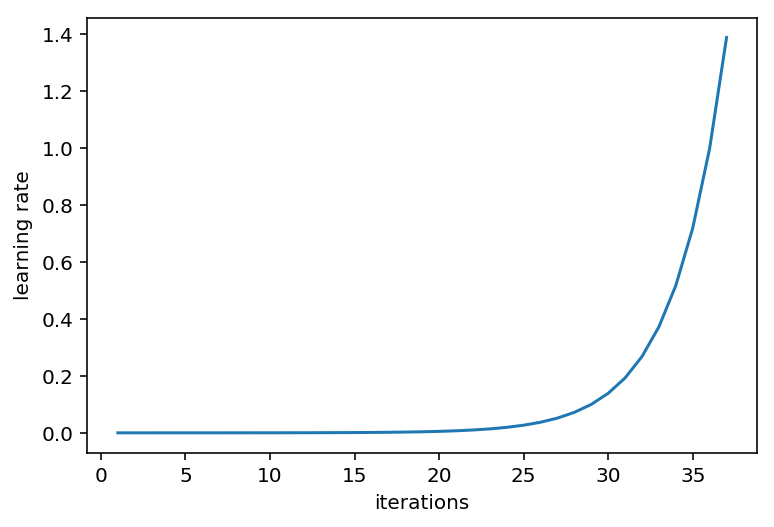

In [36]:
learn.sched.plot_lr()

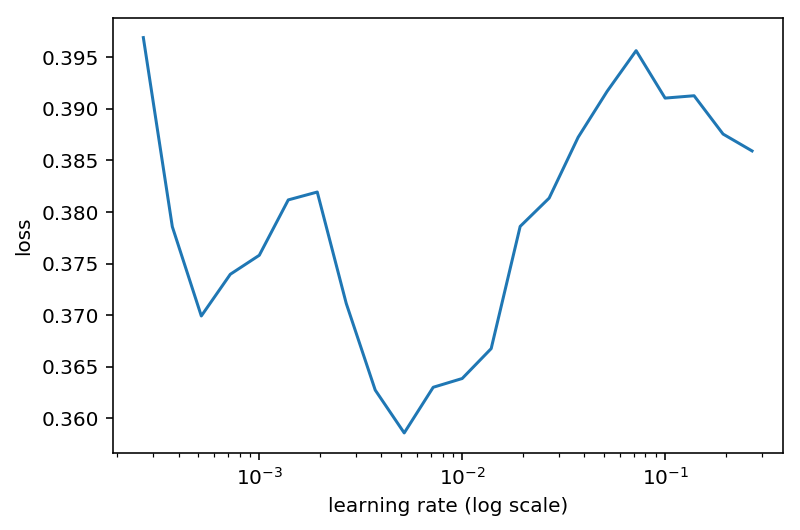

In [37]:
learn.sched.plot()

In [38]:
lr = 3e-3

In [39]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.338284, val_loss: 0.450850, accuracy: 0.810351
epoch:   1, train_loss: 0.358512, val_loss: 0.458086, accuracy: 0.806878
epoch:   2, train_loss: 0.346641, val_loss: 0.451261, accuracy: 0.815476
epoch:   3, train_loss: 0.343076, val_loss: 0.437602, accuracy: 0.813823
epoch:   4, train_loss: 0.333872, val_loss: 0.444031, accuracy: 0.810351
epoch:   5, train_loss: 0.338061, val_loss: 0.437679, accuracy: 0.824239
epoch:   6, train_loss: 0.330180, val_loss: 0.441538, accuracy: 0.803406



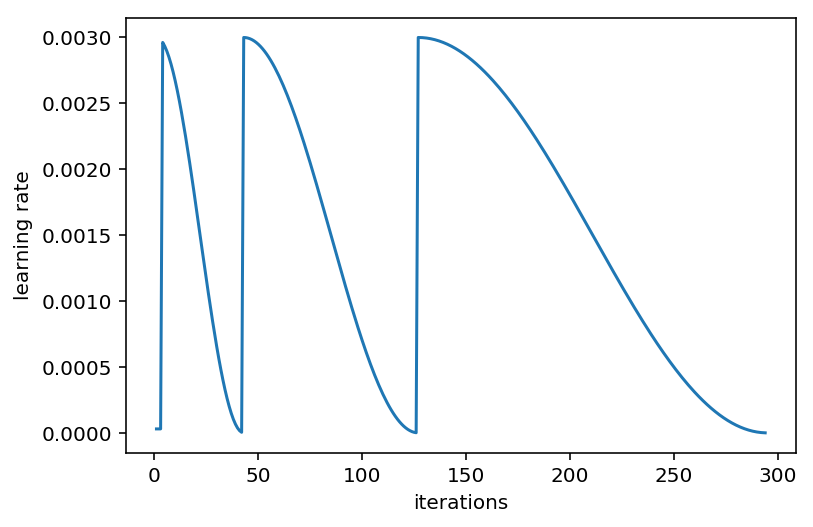

In [40]:
# stochasting gradient descent with restarts
learn.sched.plot_lr()

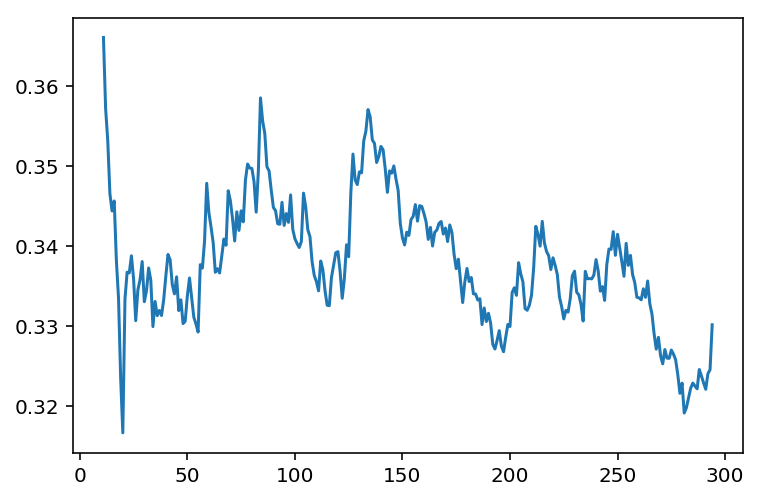

In [41]:
learn.sched.plot_loss()

****Hakan****: unfreezing at this batch size **will** murder my machine. I do not want to repeat all this over again. So I'll bring the batch size to something that may survive, like 6, and lower the learning rate proportionally.

In [43]:
learn.unfreeze()
learn.data.bs = 6
lr = lr / (32/6) # learning rate originally 3e-3

In [45]:
lrs = np.array([lr/8, lr/4, lr])
# use lr/1e2 and lr/1e1 respectively if images would've been larger in size

In [47]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.666881, val_loss: 0.576616, accuracy: 0.692130
epoch:   1, train_loss: 0.555679, val_loss: 0.513735, accuracy: 0.739087
epoch:   2, train_loss: 0.467288, val_loss: 0.495205, accuracy: 0.751323
epoch:   3, train_loss: 0.426020, val_loss: 0.475281, accuracy: 0.775463
epoch:   4, train_loss: 0.358016, val_loss: 0.498144, accuracy: 0.779101
epoch:   5, train_loss: 0.299559, val_loss: 0.487964, accuracy: 0.775628
epoch:   6, train_loss: 0.292347, val_loss: 0.498062, accuracy: 0.759921



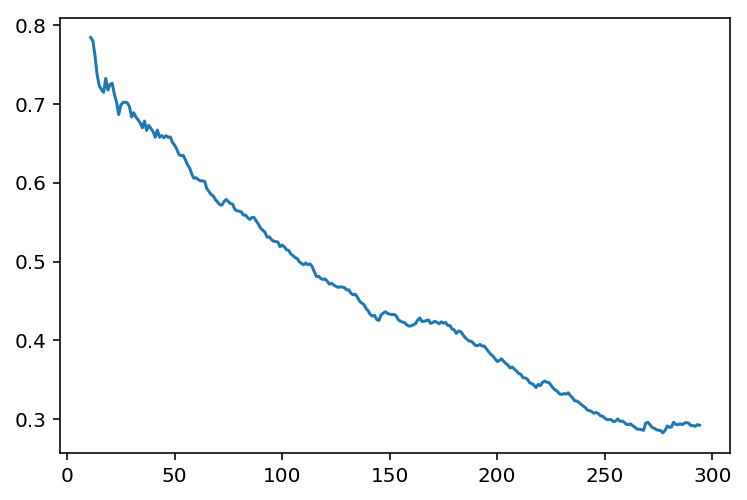

In [48]:
learn.sched.plot_loss()

## 3.1 Test Data

In [49]:
data.classes

['ice', 'ship']

In [50]:
%%time
log_preds, y = learn.TTA(is_test=True)

CPU times: user 1min 18s, sys: 27.7 s, total: 1min 46s
Wall time: 1min 14s


****Hakan****: Note: J.Howard changed `.TTA()` to return the augmented predictions without averaging them (since this wasn't optimal in all cases). So you'll have to manually average them. This Kaggle kernel was written before that change, I do it here instead.

In [54]:
ice_preds = np.mean(np.exp(log_preds), 0)

In [56]:
ice_preds[0], ice_preds.shape

(array([0.13776, 0.86224], dtype=float32), (8424, 2))

In [57]:
df = pd.DataFrame(ice_preds)
df.columns = data.classes

#### Insert ids

In [58]:
data.test_ds.fnames[:10]

['test/im_db88e2da.png',
 'test/im_98ffae4c.png',
 'test/im_bcd4f1e4.png',
 'test/im_5ee7a2d0.png',
 'test/im_598e255b.png',
 'test/im_f1565d79.png',
 'test/im_84fcd18d.png',
 'test/im_b0a3e728.png',
 'test/im_f43ac361.png',
 'test/im_bb7f2213.png']

In [59]:
df.insert(0, 'id', [y.split('/')[-1].split('_')[-1].split('.')[0] for y in 
                    data.test_ds.fnames])

In [60]:
df.head()

,id,ice,ship
0,db88e2da,0.137757,0.862243
1,98ffae4c,0.996633,0.003367
2,bcd4f1e4,0.022422,0.977578
3,5ee7a2d0,0.033069,0.966931
4,598e255b,0.000341,0.999659


****Hakan**** Note: these ids are not matching up to those in the kernel, and I've read about people having issues with submission id names not matching up, and killing their scores. If that happens in this case, I'll load in the sample submissions file and match up the id names.

In [63]:
data.classes

['ice', 'ship']

In [64]:
sub = df[['id', 'ice']]
sub.columns = ['id', 'is_iceberg']

In [68]:
sub.to_csv('data/subm/iceberg_sub_k-0.csv',index=False)

In [69]:
FileLink('data/subm/iceberg_sub_k-0.csv')

/home/wnixalo/iceberg/data/subm/iceberg_sub_k-0.csv

****Hakan****: this got a public score of `0.4197`. Hmm.. Still 2921/3337 in rankings though..

## Validation Analysis

In [70]:
data.classes

['ice', 'ship']

#### Looking at the validation set

In [71]:
y_true = data.val_y
y_true.shape

(277,)

#### Looking at the initial validation scores

In [72]:
log_preds = learn.predict()
log_preds.shape

(277, 2)

In [73]:
log_preds[:10]

array([[-0.04441, -3.1364 ],
       [-0.01058, -4.55379],
       [-0.07666, -2.6065 ],
       [-1.8488 , -0.17129],
       [-1.91278, -0.15978],
       [-0.33011, -1.26886],
       [-0.69585, -0.69045],
       [-0.00603, -5.11347],
       [-0.01074, -4.53918],
       [-1.15039, -0.38055]], dtype=float32)

In [74]:
preds = np.argmax(log_preds, axis=1) # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])       # P(ship)
probs[:10]

array([0.04344, 0.01053, 0.07379, 0.84257, 0.85233, 0.28115, 0.50135, 0.00602, 0.01068, 0.68349],
      dtype=float32)

In [75]:
preds.shape

(277,)

Confusion matrix, without normalization
[[106  33]
 [ 33 105]]


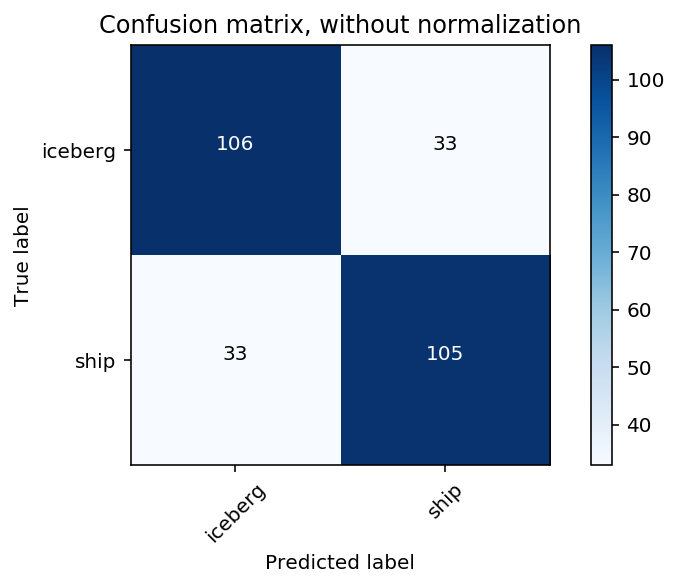

In [76]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['iceberg','ship'],
                      title='Confusion matrix, without normalization')

## Future Improvements:

### Apply Filters

In [77]:
def preprocess(img):
    img_array = np.array(img)
    img = img.filter(ImageFilter.MedianFilter(5))
    img = img.filter(ImageFilter.SHARPEN)
    img = img.filter(ImageFilter.DETAIL)    

    post_array = np.array(img)
    fig = plt.figure(1,figsize=(10,8))

    ax = fig.add_subplot(2,2,1)
    ax.imshow(img_array)
    ax = fig.add_subplot(2,2,2)
    ax.imshow(post_array)
    return post_array

def saveNpAsImg(npimg):
    PILIMG = Image.fromarray(img_array)

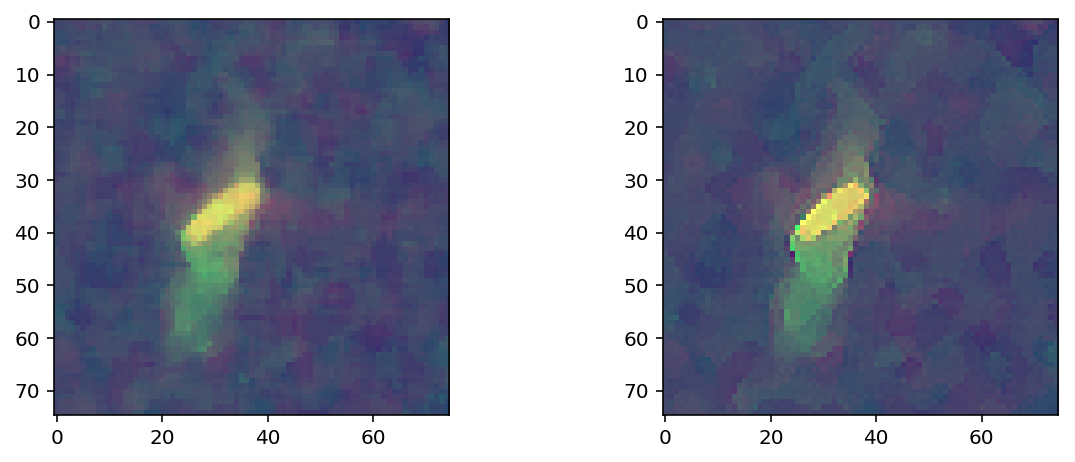

In [81]:
img = Image.open('data/valid/ship/ship_126.png')
tt = preprocess(img)

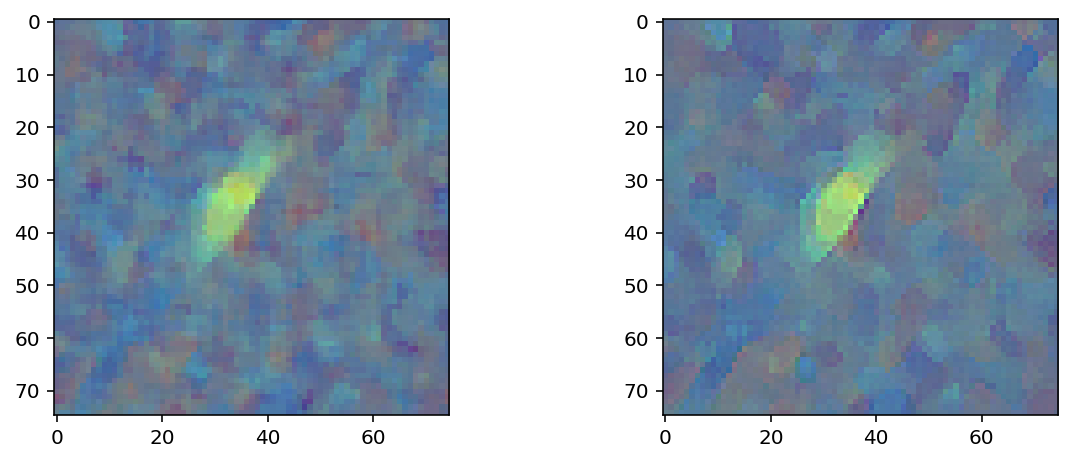

In [82]:
img = Image.open('data/valid/ice/ice_511.png')
tt = preprocess(img)

****Hakan****: aha, these are obviously machine generated test images. Hmm.

Well I can improve my score using this notebook by kicking out the validation set and training on everything. I can probably do better by not training the convolutional layers also, as that just served to increase my validation loss a bit and overfit to the training set.

Furthermore I could take a look at different architectures.

In [83]:
import cv2
img = cv2.imread('data/valid/ice/ice_511.png')

In [86]:
img.shape

(75, 75, 3)

In [87]:
# 3x3 pixel snapshop across all color channels
img[:3,:3,:]

array([[[153, 112,  88],
        [153, 115,  94],
        [151, 115,  95]],

       [[149, 112,  97],
        [150, 115,  96],
        [145, 119,  94]],

       [[143, 115, 102],
        [141, 115, 105],
        [147, 119, 111]]], dtype=uint8)

****Hakan****: See this is what I don't like about this method. The data's been ruined in the conversion to 3-channel data. Those floating-point values had 6-digit decimal precision (that's what, 20-bit integer precision, not counting digits left of the point?)... all of that is lost in the conversion to an 8-bit integer.

Unfortunately I got horrible results in my two attempts today. I'll try this notebook again tomorrow (today, now..) trained on the full dataset and submit. Then I'll try saving everything to disk, and use the standard `.from_paths` loading method and see how that goes.

After that I can maybe see what the hell I'm doing wrong. Are the ConvNet activations just not calibrated to handle the dataset in its original form? That may be a possibility.

Wayne Nixalo -- 22-Jan-2017 00:11